In [1]:
# !pip install folium pandas geopandas geopy nominatim openpyxl contextily

In [2]:
from geo_functions import *
import altair as alt
import json
import datetime
import contextily as cx
import numpy as np
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from geopy.geocoders import MapQuest
from geopandas.tools import geocode
import geopandas as gpd

# LOAD AND VERIFY DATA

In [3]:
gdf = read_excel_data()

Read gdf with shape (4347, 23) from ./data/gdf_patched.xlsx


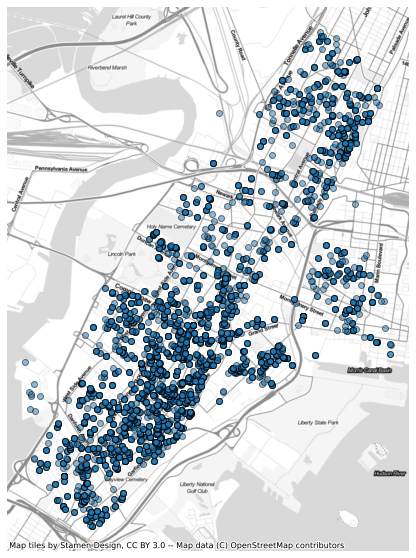

In [4]:
# quickmap 
gdf_tmp = gdf.set_crs(epsg=4326)
gdf_reproj = gdf_tmp.to_crs(epsg=3857)
ax = gdf_reproj.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()

# EXPLORATION

In [5]:
gdf['type'].value_counts()

Vacant       4172
Abandoned     175
Name: type, dtype: int64

In [6]:
# list dates in the database
np.sort(gdf['date'].unique())

array(['2014-07-01T00:00:00.000000000', '2016-07-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2021-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [7]:
# by year, type
gdf_by_date_type = gdf.groupby(['date', 'type'])
gdf_by_date_type[['date','type']].agg('count')

date  type
date       type                 
2014-07-01 Abandoned    20    20
           Vacant      925   925
2016-07-01 Abandoned    23    23
           Vacant      908   908
2017-01-01 Abandoned    26    26
           Vacant      854   854
2018-07-01 Abandoned    41    41
           Vacant      887   887
2021-07-01 Abandoned    65    65
           Vacant      598   598

### charting for streamlit

# zone tables

In [8]:
###################################################################
# reload and prepare data

gdf = read_excel_data().set_crs(epsg=4326)
df_v = gdf[gdf['type']== 'Vacant'].copy()
df_v['year'] = df_v['date'].dt.year
df_a = gdf[gdf['type']== 'Abandoned'].copy()
df_a['year'] = df_a['date'].dt.year


Read gdf with shape (4347, 23) from ./data/gdf_patched.xlsx


## by ward

In [9]:
# load shapefile and set crs
ward_map = gpd.read_file('./maps/wards/ward2012.shp')
ward_map = ward_map.to_crs(epsg=4326)

# spatial join
gdf_by_ward=gpd.sjoin(gdf, ward_map, how='left', predicate="within")
# make pivot table
table = pd.pivot_table(gdf_by_ward, values='street_address', index=['WARD2'],
                    columns=['date'], aggfunc=np.size)
# clean up and render

gdf_by_ward['year'] = gdf_by_ward['date'].dt.year

result = pd.pivot_table(gdf_by_ward, values='street_address', index=['WARD2'],
                    columns=['year'], aggfunc=np.size)
result[2019] = ''
result[2020] = ''
result = result.sort_index(axis=1)
result

year,2014,2016,2017,2018,2019,2020,2021
WARD2,,,,,,,
A,200,198,194,208,,,114
B,140,137,122,137,,,82
C,66,61,54,60,,,74
D,108,106,104,114,,,74
E,49,46,35,38,,,53
F,382,382,370,370,,,265


## by neighborhood

In [10]:
# load shapefile and set crs
neighborhood_map = gpd.read_file('./maps/neighborhoods/Neighborhoods3.shp')
neighborhood_map = neighborhood_map.to_crs(epsg=4326)

# spatial join
gdf_by_neighborhood=gpd.sjoin(gdf, neighborhood_map, how='left', predicate="within")

gdf_by_neighborhood.District.unique()

array(['Downtown', 'Heights', 'Journal Sq', 'Bergen-Lafayette',
       'West Side', 'Greenville', nan], dtype=object)

<AxesSubplot:>

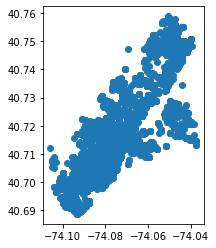

In [11]:
gdf_by_neighborhood.plot()

In [12]:
# make pivot table
table = pd.pivot_table(gdf_by_neighborhood, values='full_address', index=['Nghbhd'],
                    columns=['date'], aggfunc=np.size)
# clean up and render

gdf_by_neighborhood['year'] = gdf_by_neighborhood['date'].dt.year

result = pd.pivot_table(gdf_by_neighborhood, values='street_address', index=['District'],
                    columns=['year'], aggfunc=np.size)
result[2019] = ''
result[2020] = ''
result = result.sort_index(axis=1).fillna('')
result

year,2014,2016,2017,2018,2019,2020,2021
District,,,,,,,
Bergen-Lafayette,353,352,343,338,,,241
Downtown,58,55,43,47,,,55
Greenville,265,261,255,277,,,167
Heights,138,133,129,144,,,98
Journal Sq,35,33,28,27,,,46
West Side,96,96,81,94,,,55


In [13]:
# make pivot table
table = pd.pivot_table(gdf_by_neighborhood, values='full_address', index=['Nghbhd'],
                    columns=['date'], aggfunc=np.size)
# clean up and render

gdf_by_neighborhood['year'] = gdf_by_neighborhood['date'].dt.year

result = pd.pivot_table(gdf_by_neighborhood, values='street_address', index=['Nghbhd'],
                    columns=['year'], aggfunc=np.size)
result[2019] = ''
result[2020] = ''
result = result.sort_index(axis=1).fillna('')

# BUG why float all of a sudden?
result

year,2014,2016,2017,2018,2019,2020,2021
Nghbhd,,,,,,,
Bates,5.0,5.0,5.0,5.0,,,2.0
Bayside,11.0,12.0,8.0,12.0,,,3.0
Bergen Hill,66.0,68.0,66.0,64.0,,,50.0
Canal Crossing,,1.0,1.0,1.0,,,2.0
Country Village,6.0,7.0,8.0,11.0,,,2.0
Hamilton Park,8.0,7.0,8.0,8.0,,,9.0
Harbor Place,1.0,1.0,1.0,1.0,,,
Harsimus Cove,14.0,12.0,8.0,8.0,,,13.0
Hudson City,59.0,63.0,64.0,74.0,,,44.0


***

# by property

In [14]:
# problem children
repeat_offenders = gdf.groupby('street_address').size().sort_values(ascending=False)
repeat_offenders

street_address
2456 KENNEDY BOULEVARD    8
182 CLAREMONT AVENUE      8
107 BOYD AVENUE           8
27 BALDWIN AVENUE         7
60 SEIDLER STREET         7
                         ..
128 South Street          1
128 WEBSTER AVENUE        1
128 WOODWARD STREET       1
301 Fairmount Avenue      1
 ACADEMY STREET           1
Length: 2010, dtype: int64

In [15]:
# display first case
i = 0

for street_address,record_count in repeat_offenders.iteritems():
    group = gdf.groupby('street_address').get_group(street_address)
    display(group[['street_address', 'date', 'type']])
    if i==1:
        break
    i += 1

,street_address,date,type
3926,2456 KENNEDY BOULEVARD,2014-07-01,Vacant
3929,2456 KENNEDY BOULEVARD,2018-07-01,Vacant
3935,2456 KENNEDY BOULEVARD,2016-07-01,Vacant
3953,2456 KENNEDY BOULEVARD,2018-07-01,Vacant
3957,2456 KENNEDY BOULEVARD,2017-01-01,Vacant
3960,2456 KENNEDY BOULEVARD,2014-07-01,Vacant
3961,2456 KENNEDY BOULEVARD,2017-01-01,Vacant
3962,2456 KENNEDY BOULEVARD,2016-07-01,Vacant


,street_address,date,type
2753,182 CLAREMONT AVENUE,2016-07-01,Vacant
2754,182 CLAREMONT AVENUE,2016-07-01,Vacant
2758,182 CLAREMONT AVENUE,2014-07-01,Vacant
2759,182 CLAREMONT AVENUE,2018-07-01,Vacant
2761,182 CLAREMONT AVENUE,2018-07-01,Vacant
2762,182 CLAREMONT AVENUE,2017-01-01,Vacant
2763,182 CLAREMONT AVENUE,2017-01-01,Vacant
2765,182 CLAREMONT AVENUE,2014-07-01,Vacant


# by time

In [16]:
# just ones on the list in 2018 and 2021
filtered = gdf[gdf["date"] > datetime.datetime(2018,1,1) ]
filtered


,file,date,street_address,block,lot,owners_name,owners_address,lat_hpd,lon_hpd,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,full_address,type,Registration Date,Paid By,Secured Date,lat,lon,geometry
2,PDF on HPD site,2021-07-01,77 Sussex Street,14402,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"77 Sussex Street, Jersey City, NJ",Vacant,NaN,NaN,NaN,40.714490,-74.037446,POINT (-74.03745 40.71449)
8,vacantbuildinginventorylist2018.xlsx,2018-07-01,152 SUSSEX STREET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"152 SUSSEX STREET, Jersey City, NJ",Vacant,2017-01-21 00:00:00,2017-01-21 00:00:00,NEW APRA VBR ISSUED TO OWNER 1/21/17,40.714950,-74.040119,POINT (-74.04012 40.71495)
9,vacantbuildinginventorylist2018.xlsx,2018-07-01,152 SUSSEX STREET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"152 SUSSEX STREET, Jersey City, NJ",Vacant,2011-12-08 00:00:00,2012-02-14 00:00:00,$250.00 paid by bank 3/4/2016 VBR SENT TO NEW ...,40.714950,-74.040119,POINT (-74.04012 40.71495)
12,vacantbuildinginventorylist2018.xlsx,2018-07-01,158 SUSSEX STREET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"158 SUSSEX STREET, Jersey City, NJ",Vacant,2013-10-16 00:00:00,2013-11-11 00:00:00,$500 10-21-14 by bk $500.00 paid by bank10/26/16,40.714962,-74.040231,POINT (-74.04023 40.71496)
17,vacantbuildinginventorylist2018.xlsx,2018-07-01,163 GRAND STREET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"163 GRAND STREET, Jersey City, NJ",Vacant,2014-12-11 00:00:00,2014-12-11 00:00:00,$250 PAID 12/11/14 BY HUD AGENT,40.715593,-74.041287,POINT (-74.04129 40.71559)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,vacantbuildinginventorylist2018.xlsx,2018-07-01,326 PACIFIC AVENUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"326 PACIFIC AVENUE, Jersey City, NJ",Vacant,NaN,NaN,NaN,40.712040,-74.061795,POINT (-74.06180 40.71204)
4343,vacantbuildinginventorylist2018.xlsx,2018-07-01,109 C.COLUMBUS DRIVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"109 C.COLUMBUS DRIVE, Jersey City, NJ",Vacant,NaN,NaN,NaN,40.719764,-74.043741,POINT (-74.04374 40.71976)
4344,vacantbuildinginventorylist2018.xlsx,2018-07-01,227 CLINTON AVENUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"227 CLINTON AVENUE, Jersey City, NJ",Vacant,NaN,NaN,NaN,40.719653,-74.080186,POINT (-74.08019 40.71965)
4345,vacantbuildinginventorylist2018.xlsx,2018-07-01,147 GRANT STREET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"147 GRANT STREET, Jersey City, NJ",Vacant,NaN,NaN,NaN,40.710447,-74.083014,POINT (-74.08301 40.71045)


In [17]:
result = filtered.groupby('street_address').size().sort_values(ascending=False)
result

street_address
248 Grove Street        3
288 WHITON STREET       2
347 Arlington Avenue    2
241 4th Street          2
77 Harrison Avenue      2
                       ..
208 CLENDENNY AVENUE    1
207 STEGMAN STREET      1
207 CLINTON AVENUE      1
206 SUMMIT AVENUE       1
LI GROVE STREET         1
Length: 1504, dtype: int64

In [18]:
# display first 5 cases
i = 0

for street_address,record_count in result.iteritems():
    group = filtered.groupby('street_address').get_group(street_address)
    display(group[['street_address', 'date', 'type']])
    if i==5:
        break
    i += 1

,street_address,date,type
21,248 Grove Street,2021-07-01,Vacant
27,248 Grove Street,2021-07-01,Abandoned
28,248 Grove Street,2018-07-01,Abandoned


,street_address,date,type
1023,288 WHITON STREET,2018-07-01,Vacant
1024,288 WHITON STREET,2018-07-01,Vacant


,street_address,date,type
1770,347 Arlington Avenue,2021-07-01,Abandoned
1773,347 Arlington Avenue,2021-07-01,Vacant


,street_address,date,type
145,241 4th Street,2021-07-01,Vacant
148,241 4th Street,2021-07-01,Abandoned


,street_address,date,type
1840,77 Harrison Avenue,2021-07-01,Abandoned
1841,77 Harrison Avenue,2021-07-01,Vacant


,street_address,date,type
1412,746 Grand Street,2021-07-01,Abandoned
1414,746 Grand Street,2021-07-01,Vacant


In [19]:
# when does a property first show up
first_records = gdf[['street_address','date']].groupby(['street_address']).first()
first_records

,date
street_address,
ACADEMY STREET,2018-07-01
0 ORIENT AVENUE,2016-07-01
1 BROOK STREET,2018-07-01
1 RESERVOIR AVENUE,2018-07-01
10 BAYSIDE PLACE,2017-01-01
...,...
99 SHERMAN PLACE,2018-07-01
99.5 ORIENT AVENUE,2018-07-01
999 W Side Avenue,2021-07-01


In [20]:
last_records = gdf[['street_address','date']].groupby(['street_address']).last()
last_records

,date
street_address,
ACADEMY STREET,2018-07-01
0 ORIENT AVENUE,2017-01-01
1 BROOK STREET,2017-01-01
1 RESERVOIR AVENUE,2018-07-01
10 BAYSIDE PLACE,2018-07-01
...,...
99 SHERMAN PLACE,2018-07-01
99.5 ORIENT AVENUE,2018-07-01
999 W Side Avenue,2021-07-01


In [21]:
duration_on_list = first_records.join(last_records,  how='left', lsuffix='_left', rsuffix='_right')
duration_on_list['duration'] = duration_on_list['date_right'] - duration_on_list['date_left']
duration_on_list.sort_values(['date_right'], ascending=False)

,date_left,date_right,duration
street_address,,,
415.5 Monmouth Street,2021-07-01,2021-07-01,0 days
365 Bergen Avenue,2021-07-01,2021-07-01,0 days
17 Fulton Avenue,2021-07-01,2021-07-01,0 days
17 Perrine Avenue,2021-07-01,2021-07-01,0 days
37 Gardner Avenue,2021-07-01,2021-07-01,0 days
...,...,...,...
274A GRANT AVENUE,2017-01-01,2014-07-01,-915 days
218 LINDEN AVENUE,2018-07-01,2014-07-01,-1461 days
652 LIBERTY AVENUE,2014-07-01,2014-07-01,0 days


## abandoned only

In [22]:
# abandoned for more than 1 time period
gdf_a = gdf[gdf["type"] == 'Abandoned' ]
for index, value in (gdf_a.groupby('street_address').size().sort_values(ascending=False)).iteritems():
    print (index, '\t\t\t', value )

248 Grove Street 			 5
329 Forrest st 			 4
142 Boyd Ave 			 4
67 Clerk St 			 4
167 Armstrong Ave 			 4
165 Clerk St 			 4
163 Clerk St 			 4
671 Palisade Ave 			 4
182 Claremont Ave 			 4
148-150 Fulton Ave 			 4
80 Bowers Street 			 4
9 Myrtle Ave 			 4
35 Dwight St 			 4
125 Monitor St 			 4
2131 Kennedy Blvd 			 4
81 Orient Ave 			 3
18 McDougall St 			 3
332 Whiton St 			 3
454 Palisade Ave 			 2
201 New York Ave. 			 2
459 Palisade Ave 			 2
404 Palisade Ave 			 2
461 Palisade Ave 			 2
37.5 Oak Street 			 2
219 Clendenny Ave 			 2
354 Ogden Ave 			 2
364-366 Palisade Ave 			 2
4 Mercer Street 			 1
360 Central Avenue 			 1
364-366 Palisade Avenue 			 1
358 Central Avenue 			 1
357 4th Street 			 1
355.5 4th Street 			 1
354 Oak Street 			 1
347 Arlington Avenue 			 1
345 Claremont Ave 			 1
337 Communipaw Avenue 			 1
332 Whiton Street 			 1
332 Palisade Ave 			 1
404 Orient Ave 			 1
10 Morton Place 			 1
438 Ocean Avenue 			 1
44 Union Street 			 1
98 Myrtle Avenue 			 1
98 M

# PRESENTATION

In [23]:
gdf['date'].unique()

array(['2014-07-01T00:00:00.000000000', '2016-07-01T00:00:00.000000000',
       '2021-07-01T00:00:00.000000000', '2017-01-01T00:00:00.000000000',
       '2018-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [24]:
# filter by date
gdf_cropped = gdf[gdf['date']==datetime.datetime(2021,7,1)]
gdf_cropped.shape

(663, 23)

### folium marker map (1 year)

In [25]:
# MAKE MAP
# https://geopandas.readthedocs.io/en/latest/gallery/plotting_with_folium.html

# Stamen Toner
map = folium.Map(
    location=[40.7128,-74.1],
    tiles='Stamen Toner',
    zoom_start=14)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in gdf_cropped.geometry ]


# Iterate through list and add a marker for each address, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    #assign a color marker for the type
    if gdf_cropped['type'].iloc[i] == "Abandoned":
        type_color = "red"
    elif gdf_cropped['type'].iloc[i] == "Vacant":
        type_color = "orange"
    else:
        type_color = "gray"

        
    # alternate symbol
    # adapted from
    # https://stackoverflow.com/questions/33575053/change-marker-in-folium-map
    # and https://stackoverflow.com/questions/63152298/updating-folium-changed-the-popup-box-width
    
    html = "Address: " + str(gdf_cropped.street_address.iloc[i]) + '<br>' + \
           "Date: " + str(gdf_cropped.date.iloc[i]) + '<br>' + \
           "Status: " + str(gdf_cropped['type'].iloc[i])
    iframe = folium.IFrame(html)
    popup = folium.Popup(iframe,
                         min_width=250,
                         max_width=250)
    
    map.add_child(folium.CircleMarker(location = coordinates, 
                                      radius = 5, 
                                      popup = popup,
                                      fill_color=type_color,
                                      color=type_color, 
                                      fill_opacity=0.7))
    
    i = i + 1

# draw map
map

## debugging the grey dots

In [26]:
gdf_cropped['type'].unique()

array(['Vacant', 'Abandoned'], dtype=object)

In [27]:
gdf_cropped['type'].value_counts()

Vacant       598
Abandoned     65
Name: type, dtype: int64

In [28]:
gdf_cropped[gdf_cropped['type'].isna()]

,file,date,street_address,block,lot,owners_name,owners_address,lat_hpd,lon_hpd,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,full_address,type,Registration Date,Paid By,Secured Date,lat,lon,geometry


# TODO

## TODO heatmap

In [29]:
# https://geopandas.readthedocs.io/en/latest/gallery/plotting_with_folium.html

# This example uses heatmaps to visualize the density of volcanoes
# which is more in some parts of the world compared to others.

from folium import plugins

map = folium.Map(location = [15,30], tiles='Cartodb dark_matter', zoom_start = 2)

heat_data = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry ]

heat_data
plugins.HeatMap(heat_data).add_to(map)

map

NameError: name 'geo_df' is not defined

## TODO a map using marker clusters (what's the mapped variable?)

In [ ]:
# # folium marker clusters
# from folium.plugins import MarkerCluster
# locations = []

# # City location geometries to a list of latlongs pairs  
# for idx, row in gdf.iterrows():
#     locations.append([row['geometry'].y, row['geometry'].x])

#     # Empty canvas
# m = folium.Map(
#     location=[40.7128,-74.1],
#     tiles='Stamen Toner',
#     zoom_start=12)

# # Markercluster
# m.add_child(MarkerCluster(locations=locations))
# m

## parcel polygons map

In [ ]:
# # load the parcel map shapefile as a gdf
# parcelmap = gpd.read_file(r'../../_gis/maps/NJ/_017_HUDSON/parcels_shp_dbf_Hudson/HudsonCountyParcels.shp')

In [ ]:
# parcelmap.plot(figsize=(17,17))

## TODO a chloropleth on parcels what's the mapped variable?)

In [ ]:
# chloropleth mapping in Folium
# https://medium.com/analytics-vidhya/create-and-visualize-choropleth-map-with-folium-269d3fd12fa0

In [ ]:
# # parcels map
# style_function = lambda x: {'fillColor': '#00ff00'}

# jc_parcels_gdf = geopandas.read_file('https://njgin.state.nj.us/download2/parcels/parcels_shp_dbf_Hudson.zip')
# folium.GeoJson(data=jc_parcels_gdf["geometry"], style_function=style_function).add_to(map)
# map